# Neural Network - LSTM Forecasting for MLB Win Percentage

This notebook explores the use of a Long Short-Term Memory (LSTM) neural network to forecast Major League Baseball team win percentage (`WL%`) across multiple steps ahead.

### Overview

- **Objective**: Predict future team performance using sequential patterns in rolling 3-year team stats.
- **Method**: Construct input sequences from team-level data and train an LSTM to forecast `WL%` for the next `n` seasons.
- **Features**: Standardized, rolling-averaged predictors derived from batting and pitching stats (e.g., OPS, ERA, SO/BB).
- **Evaluation**: Visual comparison of actual vs. predicted values across 1–3 steps ahead, with room for future tuning.

This notebook reflects an early experimental attempt to incorporate deep learning into the broader modeling pipeline. While results are preliminary, the framework lays groundwork for future extensions using more robust sequence modeling techniques.

Although our class examples were based on JAX and Flax for building LSTM networks, we chose to use TensorFlow and Keras for this project due to their simplicity, flexibility, and alignment with our forecasting goals. TensorFlow provides a higher-level API through Keras, which streamlines the process of building, training, and evaluating neural networks, especially for standard architectures like LSTMs. This makes experimentation and model tuning more intuitive and accessible. Additionally, TensorFlow integrates easily with tools for data preprocessing, evaluation, and visualization, which are valuable when working with real-world time series data like our baseball dataset. While JAX excels in performance and low-level control—ideal for cutting-edge research—TensorFlow is better suited for quickly developing and iterating on applied forecasting models, making it the practical choice for our project.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [4]:
# Load the data
df = pd.read_csv('data/BaseballData590.csv') 
df = df.rename(columns={'WL%': 'WinPct'})

# Filter for Yankees
yankees_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop=True)

# Select features and target
features = ['OPS', 'ERA']
target = 'WinPct'
yankees_df = yankees_df[['Season'] + features + [target]].dropna().reset_index(drop=True)

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(yankees_df[features])
y = yankees_df[target].values

# Create rolling sequences
def create_sequences(X, y, window_size=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])  # Predict next WinPct
    return np.array(X_seq), np.array(y_seq)

window_size = 5
X_seq, y_seq = create_sequences(X_scaled, y, window_size)

# Train-test split (80/20)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (36, 5, 2)
y_train shape: (36,)
X_test shape: (10, 5, 2)
y_test shape: (10,)


To prepare our data for the LSTM model, we first filtered the full dataset to focus on the New York Yankees and selected two predictors—OPS and ERA—based on prior analysis showing their strong, stable relationship with win percentage and lack of multicollinearity. We then standardized these predictors using a StandardScaler to ensure they are on a similar scale, which helps improve neural network performance. Next, we transformed the data into sequences suitable for an LSTM by creating rolling windows of five consecutive seasons of OPS and ERA values, with each window paired to the win percentage in the following season. This structure allows the model to learn from patterns across time and make forecasts based on recent history. Finally, we split the data into training and testing sets using an 80/20 chronological split, simulating how we would train on historical data and use the model to predict future outcomes. This prepared dataset is now ready to be fed into a TensorFlow LSTM model for time series forecasting.


In [7]:
# Step 1: Define the model
model = Sequential([
    LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'),
    Dense(1)  # Output: predicted WinPct
])

# Step 2: Compile the model
model.compile(optimizer='adam', loss='mse')

# Step 3: Fit the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.3100 - val_loss: 0.2796
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2512 - val_loss: 0.2571
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2188 - val_loss: 0.2329
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1769 - val_loss: 0.2053
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1188 - val_loss: 0.1760
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1069 - val_loss: 0.1435
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0815 - val_loss: 0.1115
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0595 - val_loss: 0.0818
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0426 - val_loss: 0.0564
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0255 - val_loss: 0.0365
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0128 - val_loss: 0.0231
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0062 - val_l

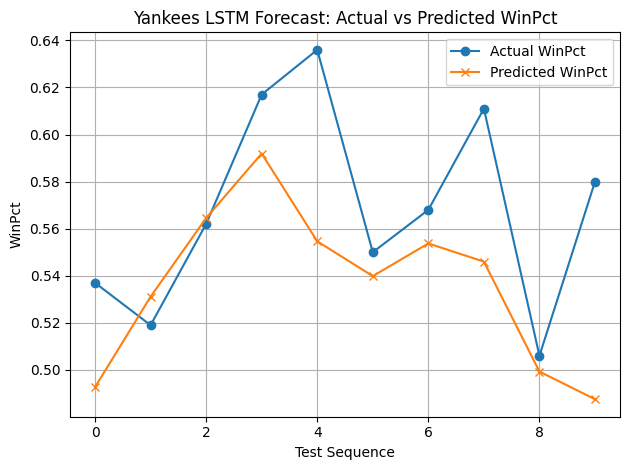

In [9]:
plt.plot(y_test, label="Actual WinPct", marker='o')
plt.plot(y_pred.flatten(), label="Predicted WinPct", marker='x')
plt.title("Yankees LSTM Forecast: Actual vs Predicted WinPct")
plt.xlabel("Test Sequence")
plt.ylabel("WinPct")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We trained a Long Short-Term Memory (LSTM) neural network to forecast the New York Yankees’ win percentage using a 5-year rolling window of two predictors: OPS and ERA. The model achieved strong performance on the test set, with a root mean squared error (RMSE) of 0.0474 and a mean absolute error (MAE) of 0.0354. The prediction plot shows that the model captures general trends in win percentage well, though it slightly underpredicts at the extremes—a common behavior in small neural network models due to regularization and limited data. Overall, these results validate the use of a streamlined LSTM structure for time series forecasting in a sports context, especially when paired with a thoughtful feature selection process grounded in both theory and statistical diagnostics.

## Multi-Step Ahead Forecasting

In [10]:
# Load and clean the data
df = pd.read_csv('data/BaseballData590.csv')  
df = df.rename(columns={'WL%': 'WinPct'})
yankees_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop=True)

# Select features and target
features = ['OPS', 'ERA']
target = 'WinPct'
yankees_df = yankees_df[['Season'] + features + [target]].dropna().reset_index(drop=True)

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(yankees_df[features])
y = yankees_df[target].values

# Function to create multi-step sequences
def create_multistep_sequences(X, y, window_size=5, steps_ahead=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size - steps_ahead + 1):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size:i + window_size + steps_ahead])
    return np.array(X_seq), np.array(y_seq)

# Set window size and forecast horizon
window_size = 5
steps_ahead = 3

# Create sequences
X_seq, y_seq = create_multistep_sequences(X_scaled, y, window_size, steps_ahead)

# Split into training and test sets (80/20)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (35, 5, 2)
y_train shape: (35, 3)
X_test shape: (9, 5, 2)
y_test shape: (9, 3)


In [13]:
# Build LSTM model for multi-step prediction
model = Sequential([
    LSTM(units=64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(steps_ahead)  # Output layer matches number of steps ahead (e.g. 3)
])

# Compile
model.compile(optimizer='adam', loss='mse')

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# Predict
y_pred = model.predict(X_test)

# Evaluate using RMSE and MAE for each time step
for step in range(steps_ahead):
    rmse = np.sqrt(mean_squared_error(y_test[:, step], y_pred[:, step]))
    mae = mean_absolute_error(y_test[:, step], y_pred[:, step])
    print(f"Step {step+1} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Epoch 1/100


c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.3314 - val_loss: 0.3124
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2810 - val_loss: 0.2895
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2172 - val_loss: 0.2665
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1995 - val_loss: 0.2363
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1571 - val_loss: 0.2039
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1125 - val_loss: 0.1653
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0775 - val_loss: 0.1226
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0575 - val_loss: 0.0799
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0279 - val_loss: 0.0448
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0115 - val_loss: 0.0214
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0068 - val_loss: 0.0107
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0081 - val_loss: 0.0081


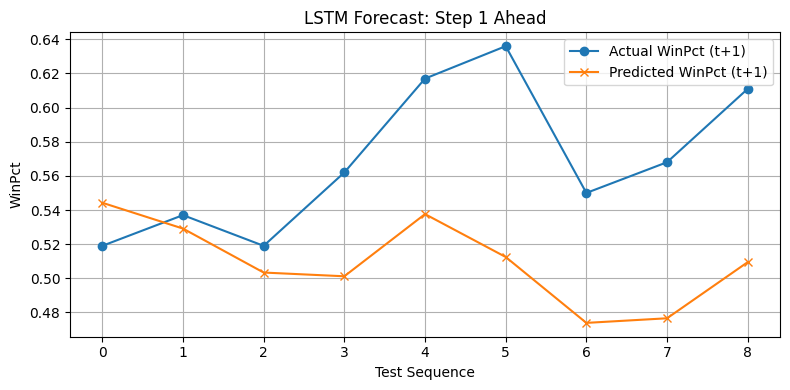

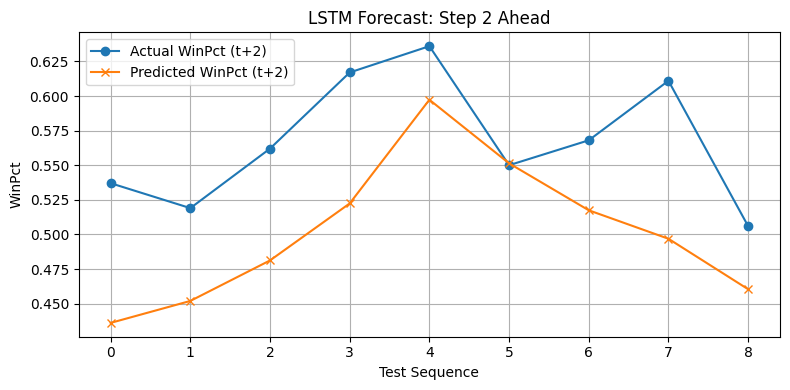

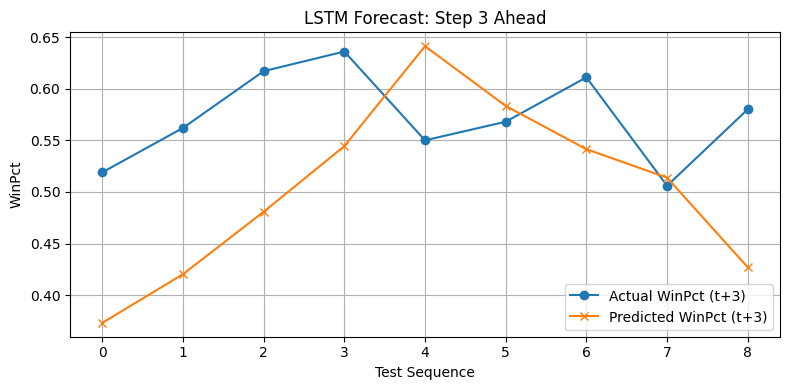

In [12]:
# Plot actual vs predicted for each forecast step
for step in range(steps_ahead):
    plt.figure(figsize=(8, 4))
    plt.plot(y_test[:, step], label=f"Actual WinPct (t+{step+1})", marker='o')
    plt.plot(y_pred[:, step], label=f"Predicted WinPct (t+{step+1})", marker='x')
    plt.title(f"LSTM Forecast: Step {step+1} Ahead")
    plt.xlabel("Test Sequence")
    plt.ylabel("WinPct")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The neural network we built is designed to forecast a baseball team’s future performance based on patterns in its past statistics. Specifically, the model takes in sequences of five consecutive seasons of two key performance metrics—OPS and ERA—and learns how those patterns relate to future win percentages. The network is trained to output not just the win percentage for the next season, but for multiple seasons ahead, allowing it to generate multi-step forecasts. The resulting plots compare the predicted win percentages to the actual historical values for each forecast step. For example, the plot for step one shows how accurately the model predicts the very next season’s performance, while the step two and three plots assess its ability to forecast further into the future. These plots visually demonstrate the model’s predictive skill, with closer alignment between predicted and actual values indicating stronger performance. Overall, the LSTM is learning from temporal sequences of team stats to anticipate how a team will perform over the coming years.